# Transaction data simulator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## Customer profile generation

In [2]:
import random

def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [3]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


## Terminal profiles generation

In [4]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [5]:
n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 0)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


## Association of customer profiles to terminals

In [6]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

In [7]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
# And get the list of terminals within radius of $50$ for the last customer
get_list_terminals_within_radius(customer_profiles_table.iloc[4], x_y_terminals=x_y_terminals, r=50)

[2, 3]

In [8]:
%%capture

terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

# Plot locations of terminals
ax.scatter(terminal_profiles_table.x_terminal_id.values, 
           terminal_profiles_table.y_terminal_id.values, 
           color='blue', label = 'Locations of terminals')

# Plot location of the last customer
customer_id=4
ax.scatter(customer_profiles_table.iloc[customer_id].x_customer_id, 
           customer_profiles_table.iloc[customer_id].y_customer_id, 
           color='red',label="Location of last customer")

ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))

# Plot the region within a radius of 50 of the last customer
circ = plt.Circle((customer_profiles_table.iloc[customer_id].x_customer_id,
                   customer_profiles_table.iloc[customer_id].y_customer_id), radius=50, color='g', alpha=0.2)
ax.add_patch(circ)

fontsize=15

ax.set_title("Green circle: \n Terminals within a radius of 50 \n of the last customer")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
    
ax.set_xlabel('x_terminal_id', fontsize=fontsize)
ax.set_ylabel('y_terminal_id', fontsize=fontsize)

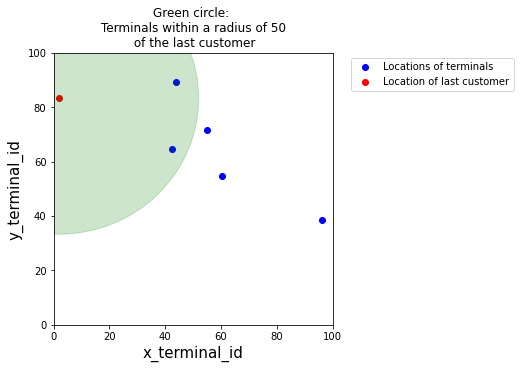

In [9]:
terminals_available_to_customer_fig

## Generation of transactions

In [10]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)

                    available_terminals = get_list_terminals_within_radius(customer_profile, x_y_terminals=terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float), r=50)
                    
                    if len(available_terminals)>0:
                        
                        terminal_id = random.choice(available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  

In [11]:
transaction_table_customer_0=generate_transactions_table(customer_profiles_table.iloc[0], 
                                                         start_date = "2018-04-01", 
                                                         nb_days = 5)
transaction_table_customer_0

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2018-04-01 07:19:05,0.0,3,123.59,26345,0
1,2018-04-01 19:02:02,0.0,3,46.51,68522,0
2,2018-04-01 18:00:16,0.0,0,77.34,64816,0
3,2018-04-02 15:13:02,0.0,2,32.35,141182,1
4,2018-04-02 14:05:38,0.0,3,63.30,137138,1
5,2018-04-02 15:46:51,0.0,3,13.59,143211,1
6,2018-04-02 08:51:06,0.0,2,54.72,118266,1
7,2018-04-02 20:24:47,0.0,3,51.89,159887,1
8,2018-04-03 12:15:47,0.0,2,117.91,216947,2
9,2018-04-03 08:50:09,0.0,1,67.72,204609,2


In [12]:
transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2018-04-01 07:19:05,0.0,3,123.59,26345,0
1,2018-04-01 19:02:02,0.0,3,46.51,68522,0
2,2018-04-01 18:00:16,0.0,0,77.34,64816,0
3,2018-04-02 15:13:02,0.0,2,32.35,141182,1
4,2018-04-02 14:05:38,0.0,3,63.30,137138,1
...,...,...,...,...,...,...
60,2018-04-05 07:41:19,4.0,2,111.38,373279,4
61,2018-04-05 06:59:59,4.0,3,80.36,370799,4
62,2018-04-05 17:23:34,4.0,2,53.25,408214,4
63,2018-04-05 12:51:38,4.0,2,36.44,391898,4


## Scaling up to a larger dataset

In [13]:
import time
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    # customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x: get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    # transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [15]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 500, 
                     n_terminals = 100, 
                     nb_days=183, 
                     start_date="2018-04-01", 
                     r=5)

Time to generate customer profiles table: 0.013s
Time to generate terminal profiles table: 0.002s
Time to associate terminals to customers: 0.38s
Time to generate transactions: 2.8e+02s


In [16]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2018-04-01 00:07:56,2,1,146.00,476,0
1,1,2018-04-01 00:30:05,360,1,92.74,1805,0
2,2,2018-04-01 00:32:35,183,0,39.30,1955,0
3,3,2018-04-01 00:43:59,382,1,15.35,2639,0
4,4,2018-04-01 00:45:51,381,3,23.15,2751,0
...,...,...,...,...,...,...,...
161905,161905,2018-09-30 23:32:59,140,4,97.55,15809579,182
161906,161906,2018-09-30 23:33:02,221,2,61.26,15809582,182
161907,161907,2018-09-30 23:46:15,101,4,58.80,15810375,182
161908,161908,2018-09-30 23:54:38,7,3,15.08,15810878,182


In [20]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=1000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=1000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

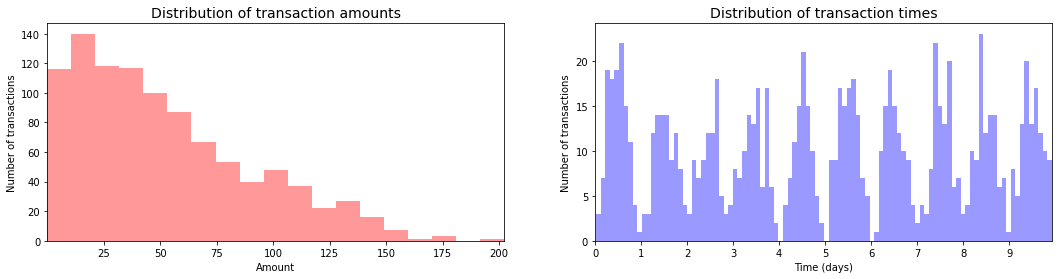

In [21]:
distribution_amount_times_fig 